# Introduction to transfer learning to CNN 

This exercise introduces transfer learning applied to image classification. Transfer learning is a poweful way to leverage Deep Learning potential. The main idea is to reuse weights trained on other tasks to the task you are carrying out.

There are two things:
- use pre-trained network with a feature extractor (layers  based model) and replace the top of the model by a new classifier. 
- use pre-trained network but fine tune part of the CNN layers as well as replace the top classifiers layers if necessary.

The final output of the model is a series of probabilities (activation scores) with dimension matching the number of classes/labels. For each image, the highest probability is taken as the label/class.

## Dataset

CIFAR 10 is an image dataset commonly used as a reference/baseline dataset in Machine Learning. It is produced by the Canadian Center for Advanced Research. It consists of set of 60,000 images of 10 classes of color images of size 32x32x3. The classes are common objects or animals. For instance, class 4 corresponds cats while class 2 corresponds to automobiles. The images are coarsened colors with Red, Blue, Green chanels. Of the 60,000 images, 50,000 are reserved for training while 10,000 are reserved for testing. 

## Training subset

Transfer learning requires fewer training samples to train models because it reuses pre-trained weigts. In this exercise, we only use:

- training: 1024 images 
- validation: 256 images
- testing: 10,000 images

We compared results for a CNN model we created to a pre-trained model with a VGG16 backbone.
 
## Interesting Links

- cifar: https://en.wikipedia.org/wiki/CIFAR-10

- lenet architecture: http://yann.lecun.com/exdb/lenet/

- lenet5: https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc3
42

- https://906-22912.medium.com/transfer-learning-a-vgg16-based-custom-cnn-for-cifar-10-image-classification-bb3a0da486d1

- https://medium.com/analytics-vidhya/the-transfer-learning-experience-with-vgg16-and-cifar-10-dataset-9b25b306a23f



# Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improves code reproducibility as well.



In [1]:
####################################    Intro to transfer learning with CNN CIFAR 10 #######################################
##############################################################################
# This script demonstrates the building of a basic CNN model to predict the label of 10 classes of a set of images.
# We use the CIFAR 10 dataset here.
#AUTHORS: Benoit Parmentier                                             
#DATE CREATED: 02/10/2022 
#DATE MODIFIED: 01/29/2023
#Version: 1
#PROJECT: Course on DL
#TO DO:
#
#COMMIT: 
#Useful links:
#https://en.wikipedia.org/wiki/CIFAR-10

##################################################################################################

###### Library used in this script

#Need some clean up here
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Deep learning packages
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils

import subprocess
import pandas as pd
import os, glob
import numpy as np
from tensorflow.keras.utils import to_categorical


np.set_printoptions(suppress=True) #suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.4f' % x) #dispaly with four decimal


The list of packages above constains some of the most common packages used in data science, deep learning.  In this exercise, we use matplotlib and seaborn to make graphs, plots and visualize images. Keras is used in creating the deep learning model. Sklearn provides many functionalities and methods (SVM, random forest etc.) for Machine Learning.

In [2]:
# functions used ot create a output directory
def create_dir_and_check_existence(path):
    
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")


def generate_accuracy(model,y_test,x_test,class_names=None):

  """ 
  Function to predict and generate accuracy metrics (precision and recall) for each model given input x and y test.

  Extended description of function. 
  
  Parameters: 
  model: keras model
  y_test: Input target for test
  y_train: target train labels used in classification
  class_names: labels for the class predicted

  Returns: 
  report_df: pandas data frame with accuracy metrics
  
  """
  
  # we can store the array in a data.frame and get the max
  y_score = model.predict(x_test)
  y_score.shape
  y_pred_test_df = pd.DataFrame(y_score)
  y_pred_test_df['y_pred_test'] = y_pred_test_df.idxmax(axis = 1) #one to go across the column for each row 
  y_pred_test_df


  y_pred_test = y_pred_test_df['y_pred_test']
  report_dict=classification_report(y_test, 
                                      y_pred_test,
                                      target_names=class_names,
                                      output_dict=True)
  report_df = pd.DataFrame(report_dict)
  #confusion_matrix_val = confusion_matrix(y_test,y_pred_test)  #not in use here
  model_name = model._name
  #display(report_df)
  report_df = (report_df.drop(columns=['macro avg','weighted avg'])
                        .drop(labels=['f1-score','support'])
                        .assign(model_name= lambda x: model_name)
                        .assign(num_param= lambda x: model.count_params())
                        .reset_index()
                        .rename(columns={'index':'metric'})
              )
  
  return report_df


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [4]:
############################################################################
#####  Parameters and argument set up ########### 

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_transfer_learning/data/'
#ARG 2
out_dir = "/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_transfer_learning"

#ARGS 3:
create_out_dir = True #create a new ouput dir if TRUE
#ARG 4
out_suffix = "intro_to_cnn_01292023" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -9999 # currently not used: Nan value
#ARG 6
random_seed=42 #not yet used

## Input data
#ARG 7-8    
fit_model = False
run_model = False #Retrain model if True
model_path = '/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_transfer_learning/models/output_data_intro_to_cnn_02212022'

In [5]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


In [6]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_to_transfer_learning/outputs/output_data_intro_to_cnn_01292023


# Workflow/pipeline

In this exercise, we will perform the analysis using a workflow that may be succintly described using the following steps:
1. **Visualization and exploration of data** 
- Obtain data from Keras 
-Visualize feature images and target value.
- Explore if data is balanced
2. **Data processing**
- change image data type
- rescale image values
- change label to one hot encoding
3. **Build and train model**
- build keras models
- fit and train models
4. **Accuracy Assessment**
- use test data to generate an accuracy assessment
- assess accuracy using precision and recall.

# 1. Visualization and exploration of the Dataset

We will first load the dataset using the keras.dataset API. Keras provides the CIFAR dataset already split into training and testing data. The input feature data is an RGB image of 10 differenct classes while the target is the label of the image.
The data loaded is in numpy format and we can check the size of the training and testing data below:

In [17]:
#example of loading the cifar10 dataset
#from keras.datasets import cifar10
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Size of the input feature CIFAR training dataset: ",x_train.shape)
print("Size of the input feature CIFAR testing dataset: ",x_test.shape)
print("Size of the input target CIFAR training dataset: ",y_train.shape)
print("Size of the input target CIFAR testing dataset: ",y_test.shape)

Size of the input feature CIFAR training dataset:  (50000, 32, 32, 3)
Size of the input feature CIFAR testing dataset:  (10000, 32, 32, 3)
Size of the input target CIFAR training dataset:  (50000, 1)
Size of the input target CIFAR testing dataset:  (10000, 1)


<class 'numpy.ndarray'>
(32, 32, 3)


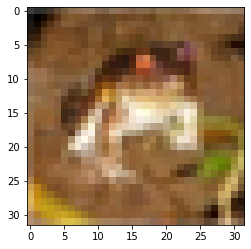

In [18]:
print(type(x_train)) #check that the data type is numpy array
print(x_train[0].shape) #selecting sample 0
plt.imshow(x_train[0])

In [19]:
print(y_train[0].shape)
y_train[0]

(1,)


array([6], dtype=uint8)

In [20]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

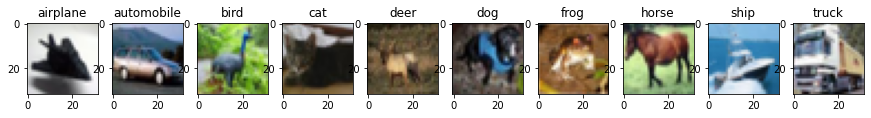

In [21]:
# Let's explore the first 10 images with labels
# Print figure with 10 random images from each
num_classes=10
#fig = plt.figure(figsize=(8,3))
f, ax = plt.subplots(1,num_classes,figsize=(15,15))

for class_val in range(num_classes):
  
    class_index = np.where(y_train[:]==class_val)[0] #returns tuple because it is a two dimensional array
    #take first element matching the class as it is relevant to the class
    image = x_train[class_index]
    #print("Image size",image.shape)
    ax[class_val].imshow(image[0])
    ax[class_val].set_title(class_names[class_val])


In [22]:
#check if dataset is balanced.
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1    2    3    4    5    6    7    8    9]
 [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]]


# 2. Data Processing

The input data comes as byte for each of the channels. This means that it is within the 0 to 255 range. Neural Networks and deep learning model converge faster when values are within the 0-1 range . We will process the data to prepare the inputs for the model in 3 steps:

- change data type for images
- change scale to 0-1
- change label to one hot encoding

In [23]:
print(x_train.dtype)
print(y_train.dtype)

uint8
uint8


First we need to convert the data type from integer to float.


In [24]:

# change data type to float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# scale between 0 and 1
x_train = x_train/255 
x_test = x_test/255

#Change label to one hot encoding using from keras.utils.to_categorical

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [25]:
y_train_cat[0] #this is now one hot encoded

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [26]:
x_train.shape[1:] #first image

(32, 32, 3)

In [27]:
#Note that the input data may need to be pre-process or transformed

#custom_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
#])



#tf.keras.applications.vgg16.preprocess_input(
#    x, data_format=None
#)
## Note that this particular normalization scheme is
## necessary since it was used for pre-training
## the network on ImageNet.
## These are the channel-means and standard deviations
## for z-score normalization.

# 3. Building and training Models

We will be using the sequential api to build the CNN model to classify the 10 CIFAR classes.
We will compare 2 model architectures:

1. model_cnn: CNN architecture using the relu function and some drop out layers
2. vgg_transfer_learning: CNN using VGG16 base model with new classifier (pre-trained model not fine tuned)

## 3.1 Build  baseline model: a CNN Neural Network for CIFAR

First, we will use a fully connected network also called dense network because every node in successive layers are connected to the next and previous layers. 
This can result in a large number of parameters even with a very simple architecture.

In [28]:
INPUT_SHAPE = x_train.shape[1:]
print(INPUT_SHAPE)

(32, 32, 3)


In [29]:
num_classes =10
model_cnn = Sequential()

## CNN part
#Block 1
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                 activation='relu', input_shape=INPUT_SHAPE))
model_cnn.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))

#Block 2
model_cnn.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))

#Block 3: 
model_cnn.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model_cnn.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2))) #becomes 4x4 image

## DNN part
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1024,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(num_classes, activation='softmax'))

# Compile model

model_cnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model_cnn._name = 'model_cnn' # set keras model name

In [30]:
model_cnn.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                     

In [31]:
if fit_model == True:
  # Fit model
  batch_size =128
  epochs = 2
  steps_per_epoch = 1
  # Fit model: takes between 50 and 60 minutes for epoch 10

  cnn_history = model_cnn.fit(x_train, 
                y_train_cat, 
                batch_size=batch_size, 
                steps_per_epoch= steps_per_epoch,
                epochs=epochs,
                validation_split = 0.2, 
                shuffle=True)

## 3.2 Build  transfer learning model: VGG16 base model

We will use the VGG16 backbone (Convolutional layers) to create a new model. We use pre-trained weights and remove the top of the model (dense neural network classifier).

In [32]:
# get VGG16 base model and define new input shape

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet

INPUT_SHAPE = [128,128,3]

base_model = keras.applications.vgg16.VGG16(input_shape = INPUT_SHAPE,
                                       weights='imagenet',
                                       include_top=False)
base_model.summary()

# Make vgg16 model layers as non trainable
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(32,32,3), name = 'input')
x = keras.layers.Resizing(height=INPUT_SHAPE[0], width=INPUT_SHAPE[1], interpolation='bilinear', crop_to_aspect_ratio=False)(inputs)
x = base_model(x)
# add new dense layers at the top
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# define and compile model
model_vgg_transfer = keras.Model(inputs=inputs, outputs=outputs)

model_vgg_transfer.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_vgg_transfer._name = 'model_vgg_transfer' # set keras model name
model_vgg_transfer.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [33]:
if fit_model == True:
  # Fit model
  batch_size =128
  epochs = 2
  steps_per_epoch = 1
  # Fit model: takes between 50 and 60 minutes for epoch 10

  cnn_history = model_vgg_transfer.fit(x_train, 
                y_train_cat, 
                batch_size=batch_size, 
                steps_per_epoch= steps_per_epoch,
                epochs=epochs,
                validation_split = 0.2, 
                shuffle=True)

In [34]:
fit_model=False

# Compiling and fitting models

In [35]:
#recompile and reset weights to random:f
model_cnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model_vgg_transfer.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
## Loop through this, this ran in 5h and 15 minutes
#vgg_transfer_learning
list_models=[model_cnn,model_vgg_transfer] #use the model
#3run_model = True
#1840s per epoch for vgg

list_hist_df=[]
steps_per_epoch = 10
epochs = 10
batch_size = 128

if run_model==True:

  for model in list_models:
  #if run_model=True then train model and store weights and history 

    # Fit model: takes between 50 and 60 minutes
    
    model_name = model._name
    history_model = model.fit(x_train, 
                y_train_cat, 
                batch_size=batch_size, 
                steps_per_epoch=steps_per_epoch,
                epochs=epochs,
                validation_split = 0.2, 
                shuffle=True)
    hist_df = pd.DataFrame(history_model.history) 

    # save to json:  
    hist_json_file = 'history_'+model_name+'_'+out_suffix+'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)
    # save to csv: 
    hist_csv_file = 'history_'+model_name+'_'+out_suffix+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    # serialize weights to HDF5
    model.save_weights(model_name+'_'+out_suffix+'.h5')
    list_hist_df.append(hist_df)
    print("Saved model to disk ", model_name)

  #if run_model=False then load models weights and loss history from h5 file
if run_model==False:
  if model_path is None:
    model_path = os.path.join(out_dir,fileglob) #classified
    print('Set model path to output directory')

  model_names=['model_cnn','model_vgg_transfer']
  i=0
  for model_name in model_names:
    print(i)
    print(model_name)
    fileglob ="*"+model_name+"*.h5"
    model_path_filename= os.path.join(model_path,fileglob) #classified
    model_path_filename = glob.glob(model_path_filename,recursive=False)[0]
    model=list_models[i]
    model.summary()
    print('This is the model path ',model_path_filename)
    model.load_weights(model_path_filename)
    fileglob ='*'+model_name+"*.csv"
    history_model_path = os.path.join(model_path,fileglob) #classified
    history_model_path = glob.glob(history_model_path,recursive=False)[0]
    hist_df = pd.read_csv(history_model_path)
    list_models[i]=model #put the updated model with weights in the list
    list_hist_df.append(hist_df)
    i=i+1

0
model_cnn
Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                         

Now let's take a look at the loss and accuracy for the training of the three models. For each epoch, keras computes a loss and accuracy metrics. We extracted these informations for the callback keras object in the previous step during the fitting process.

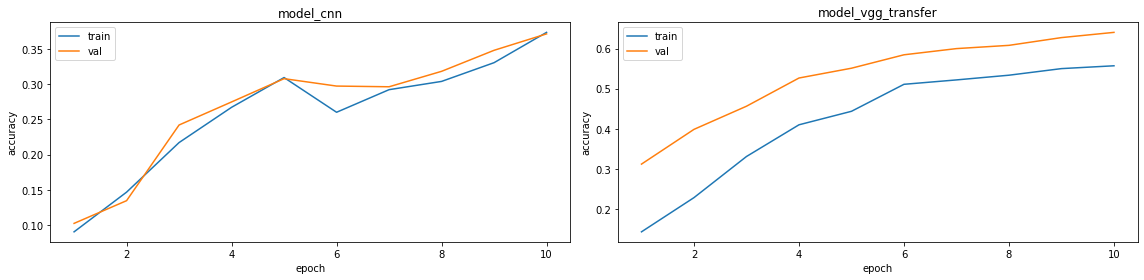

In [37]:

num_models= len(list_models)
fig, ax = plt.subplots(1,num_models,figsize=(16,4))
model_names=['model_cnn','model_vgg_transfer']

for model_val in range(num_models):
  hist_df=list_hist_df[model_val]
  hist_df['epoch']=np.arange(1,hist_df.shape[0]+1)
  ax[model_val].plot(hist_df['epoch'],hist_df['accuracy'],label='train')
  ax[model_val].plot(hist_df['epoch'],hist_df['val_accuracy'],label='val')
  ax[model_val].set_title(model_names[model_val])
  ax[model_val].set_xlabel('epoch') 
  ax[model_val].set_ylabel('accuracy') 
  ax[model_val].legend()

fig.tight_layout()

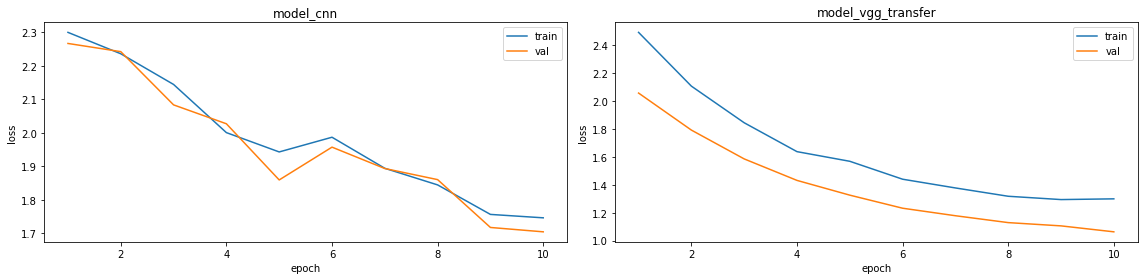

In [38]:
num_models= len(list_models)
fig, ax = plt.subplots(1,num_models,figsize=(16,4))
model_names=['model_cnn','model_vgg_transfer']


for model_val in range(num_models):
  hist_df=list_hist_df[model_val]
  hist_df['epoch']=np.arange(1,hist_df.shape[0]+1)

  ax[model_val].plot(hist_df['epoch'],hist_df['loss'],label='train')
  ax[model_val].plot(hist_df['epoch'],hist_df['val_loss'],label='val')
  ax[model_val].set_title(model_names[model_val])
  ax[model_val].set_xlabel('epoch') 
  ax[model_val].set_ylabel('loss') 
  ax[model_val].legend()

fig.tight_layout()

# Accurary Assessment and models comparison

We assess models using the test data. The steps as follow:

1. generate test samples and predict using each model
2. compute accuracy metrics
3. compare models using metrics and complexity.

In #1, we generate predictions using the test samples or the model_dnn, model_lenet and model_cnn.

In #2, we use the soft and hard predictions to generate confusion metrics and accuracy metrics such as AUC and precision, recall.

In #3, we compare the three models using the metrics as well as number of parameters (as proxy for model complexity).

In [44]:
test_image = x_test[2:3] #select third image test sample
#y_score = model_cnn.predict(test_image)
y_score = model_vgg_transfer.predict(test_image)

print(y_score)
print(class_names[np.argmax(y_score)])
y_pred_test= np.argmax(y_score)
print(y_pred_test)

1/1 [==============================] - 0s 201ms/step
[[0.09401599 0.17745899 0.03205727 0.12912938 0.10281231 0.05743331
  0.03536808 0.07899307 0.15259527 0.14013633]]
automobile
1


(1, 32, 32, 3)


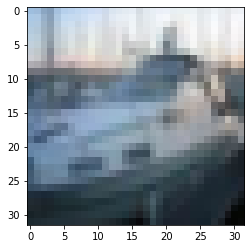

In [46]:
print(test_image.shape)
#plt.imshow(test_image[2:3])
plt.imshow(test_image[0])


In [47]:
#y_test is a OHE vector but x_test is an image!!
#y_test_cat = to_categorical(y_test, num_classes=10)
y_test_cat.shape

(10000, 10)

In [48]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
# we can store the array in a data.frame and get the max
#This steps is called 'inference' in deep learning.
#y_score = model_cnn.predict(x_test) #20 s
y_score = model_vgg_transfer.predict(x_test) #takes 29 minutes
print(type(y_score))
y_score.shape

313/313 [==============================] - 1645s 5s/step
<class 'numpy.ndarray'>


(10000, 10)

In [ ]:
y_pred_test_df = pd.DataFrame(y_score)
y_pred_test_df['y_pred_test'] = y_pred_test_df.idxmax(axis = 1) #one to go across the column for each row 

y_pred_test_df

,0,1,2,3,4,5,6,7,8,9,y_pred_test
0,0.0212,0.0623,0.0283,0.3342,0.0169,0.2350,0.0265,0.0818,0.0267,0.1673,3
1,0.1454,0.0727,0.0015,0.0023,0.0004,0.0004,0.0005,0.0005,0.7611,0.0153,8
2,0.0940,0.1775,0.0321,0.1291,0.1028,0.0574,0.0354,0.0790,0.1526,0.1401,1
3,0.5230,0.0303,0.0413,0.0397,0.0089,0.0064,0.0064,0.0065,0.3006,0.0369,0
4,0.0171,0.0079,0.1296,0.1042,0.1920,0.0428,0.4726,0.0263,0.0047,0.0029,6
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0068,0.0044,0.1636,0.1490,0.0603,0.4880,0.0421,0.0679,0.0117,0.0062,5
9996,0.0117,0.0075,0.1048,0.1843,0.1565,0.2370,0.0317,0.2205,0.0087,0.0374,5
9997,0.0004,0.0007,0.0603,0.0687,0.0091,0.8208,0.0096,0.0281,0.0011,0.0012,5
9998,0.2936,0.3657,0.0478,0.0546,0.0260,0.0149,0.0444,0.1116,0.0131,0.0282,1


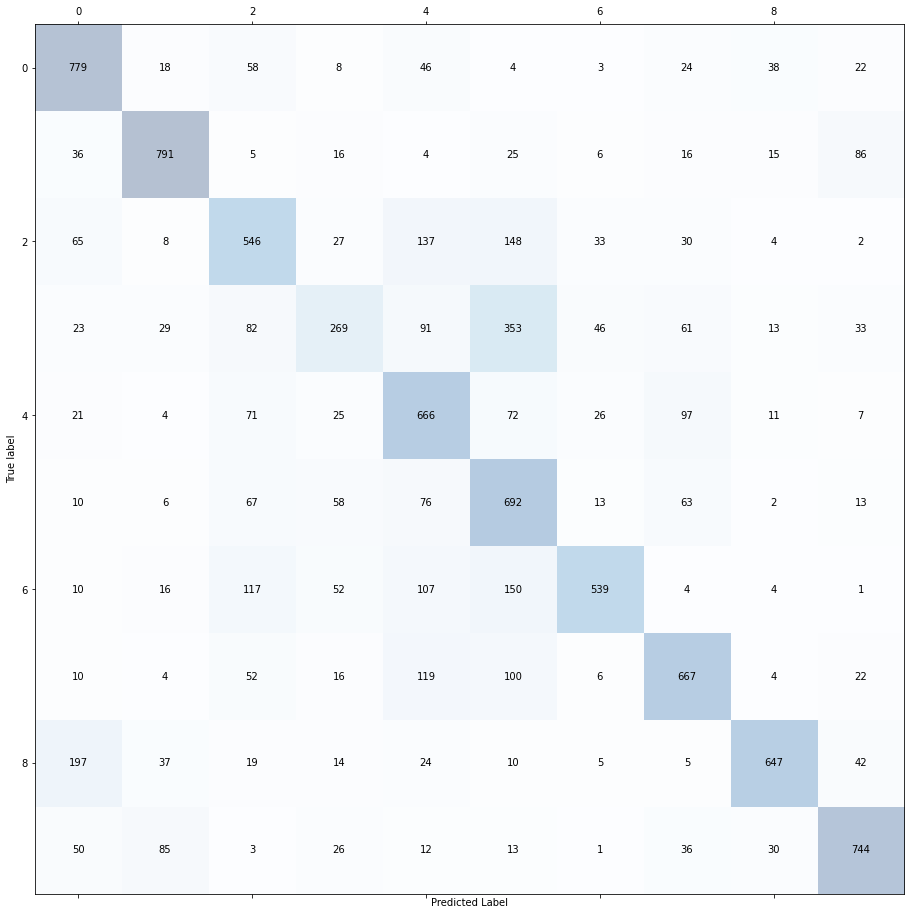

In [ ]:
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
y_pred_test = y_pred_test_df['y_pred_test']
report_dict=classification_report(y_test, 
                                      y_pred_test,
                                      output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
confusion_matrix_val = confusion_matrix(y_test,y_pred_test)

fig, ax = plt.subplots(figsize=(16,16))
ax.matshow(confusion_matrix_val,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confusion_matrix_val.shape[0]):
  for j in range(confusion_matrix_val.shape[1]):
    ax.text(x=j,y=i,
               s=confusion_matrix_val[i,j],
               va='center',
               ha='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True label')

In [ ]:
report_df
# Note we have 1000 test samples per class
#precision: number of correctly predicted categories out of predictions (True Positive/(True Positive + Positve))
#precision: number of correctly predicted categories out of predictions (True Positive/(True Positive + Positve))


,precision,recall,f1-score,support
0,0.6486,0.7790,0.7079,1000.0000
1,0.7926,0.7910,0.7918,1000.0000
2,0.5353,0.5460,0.5406,1000.0000
3,0.5264,0.2690,0.3561,1000.0000
4,0.5195,0.6660,0.5837,1000.0000
5,0.4416,0.6920,0.5392,1000.0000
6,0.7950,0.5390,0.6424,1000.0000
7,0.6650,0.6670,0.6660,1000.0000
8,0.8424,0.6470,0.7319,1000.0000
9,0.7654,0.7440,0.7546,1000.0000


Let's use a function to generate the accuracy metrics for all models.



In [ ]:
list_report_df = []
for model in list_models:
  report_df = generate_accuracy(model,y_test,x_test,class_names=class_names )
  list_report_df.append(report_df)
#list_report_df

from functools import reduce
report_df = reduce(lambda df1,df2: df1.merge(df2,"outer"),list_report_df)
report_df

313/313 [==============================] - 1624s 5s/step


,metric,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck,accuracy,model_name,num_param
0,precision,0.4871,0.5773,0.2796,0.2190,0.4226,0.3823,0.3083,0.3603,0.4043,0.5171,0.3752,model_cnn,2395434
1,recall,0.4720,0.3960,0.0260,0.3730,0.2020,0.2370,0.6200,0.5210,0.4520,0.4530,0.3752,model_cnn,2395434
2,precision,0.6486,0.7926,0.5353,0.5264,0.5195,0.4416,0.7950,0.6650,0.8424,0.7654,0.6340,model_vgg_transfer,18976458
3,recall,0.7790,0.7910,0.5460,0.2690,0.6660,0.6920,0.5390,0.6670,0.6470,0.7440,0.6340,model_vgg_transfer,18976458


A few observations that come out of the assessement:
1. accuracy show that the best model is VGG16 transfer base model. 
2. VGG16 is pre-trained on a large dataset (Imagenet), we only used 2.5% of the data or 1024 images (with 256 for validation)
3.The class with the highest prediction is ship with 0.84 using vgg transfer. The Recall is lower though with 0.64.
4. The automobile class has high precision and high recall: 0.7926 and 0.7910 respectively. 



### Understanding the number of parameters

In this exercise, we produced 2 different architectures one using a CNN trained from sracth and another one based on VGG16 

The most complex model 'model_cnn' contains 2,395,434 parameters and has 7 hidden layers (max pooling layers have no trained parameters).


The VGG16 transfer model has 18,976,458 parameters but only 4,261,770 trainable parameters. This is because we froze the base model (VGG16 feature extractor) and trained only the 'head' top part of the model.

**Model_cnn**


In [ ]:
model_cnn.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                     

In [ ]:
model_vgg_transfer.summary()

Model: "model_vgg_transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)        

# Conclusions

In this exercise, we introduced transfer learning for image classification. We used the CIFAR 10 data and predicted the category of each image out of 10 labels. We experimented with a CNN model and a VGG16 transfer model. Our transfer model used a VGG16 backbone, on top of which we added a dense neural network classifer.

As expected we found that the VGG16 performed the best. We only used about 2.56% of the original data from training (or 1024 images) for 10 epochs to show that transfer learning models require less training data and can perform well.

In [ ]:
############################# END OF SCRIPT ###################################